# Import packages

In [3]:
import torchvision.utils as vutils
import copy
import math

import os
import numpy as np
from PIL import Image, ImageFile
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as transforms

import torch.utils.data as td
import torchvision as tv
import pandas as pd
from torch.autograd import Variable

from io import BytesIO
import itertools
from image_pool import ImagePool
import time


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


# Obtain data

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

## Landscape image domain

In [6]:
batchsize = 1

In [7]:
cwd = os.getcwd()
print(cwd)  # get the current directory
landscape_root_dir = cwd + '/flickr_landscape/'  

/datasets/home/home-02/69/069/haz011/ece285/Project/Cycle-GAN


In [8]:
class LandscapeDataset(td.Dataset):
    def __init__(self, root_dir, category = "mountain", image_size = (224, 224)):
        super(LandscapeDataset, self).__init__()
        self.image_size = image_size
        self.category = category
        json_path = os.path.join(root_dir, "licenses/{}_photos_info.json".format(category))
        self.data = pd.read_json(json_path)  # read the json file 
        self.data = self.data.loc[:,self.data.iloc[2] != '3']   # drop the license which is '3'
        self.data = self.data.loc[:,self.data.iloc[2] != '6']  # drop the license which is '6'
        self.data = self.data.T   # transpose the DataFrame

        self.images_dir = os.path.join(root_dir, self.category)

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "LandscapeDataset(category={}, image_size={})". format(self.category, self.image_size)
    
    def __getitem__(self,idx):
        valid=False
        i = 0
        while not valid:
            try:
                img_path = os.path.join(self.images_dir, self.data.iloc[idx][0]) 
                img = Image.open(img_path).convert('RGB')
                valid = True
            except FileNotFoundError:
                idx = i
                i += 1
        transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ])
        x = transform(img)          # transformed image
        d = self.data.iloc[idx][2]   # license of the image
        return x

In [9]:
X_sets = LandscapeDataset(landscape_root_dir)
X_loader =  list(td.DataLoader(X_sets, batch_size = batchsize, shuffle = True, pin_memory = True))

In [10]:
len(X_loader)

469

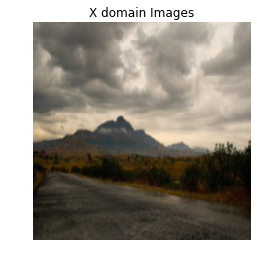

In [11]:
# plot some training images
plt.figure(figsize = (4, 4))
plt.axis('off')
plt.title('X domain Images')
plt.imshow(np.transpose(vutils.make_grid(X_loader[0].to(device)[:batchsize], padding = 2\
                                         , normalize = True).cpu(), (1, 2, 0)))

## Art style image domain

In [12]:
art_root_dir = cwd + '/wikiart/'

In [13]:
class ArtDataset(td.Dataset):
    def __init__(self, art_root_dir, mode="train", image_size=(224, 224)):
        super(ArtDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(art_root_dir, "Style/style_%s.csv" % mode))
        self.data = self.data.loc[self.data.iloc[:,1] == 4]   # vincent-van-gogh
        self.images_dir = os.path.join(art_root_dir,'wikiart')

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "ArtDataset(mode={}, image_size={})". format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        try:
            img_path = os.path.join(self.images_dir, self.data.iloc[idx][0])
            ImageFile.LOAD_TRUNCATED_IMAGES = True
            img = Image.open(img_path).convert('RGB')
        except UnicodeEncodeError:
            img_path = os.path.join(self.images_dir, self.data.iloc[idx-1][0]) 
            ImageFile.LOAD_TRUNCATED_IMAGES = True
            img = Image.open(img_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ])
        x = transform(img)
        d = self.data.iloc[idx][1]
        return x

In [14]:
Y_sets = ArtDataset(art_root_dir)
Y_loader =  list(td.DataLoader(Y_sets, batch_size = batchsize, shuffle = True, pin_memory = True))

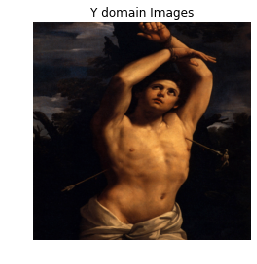

In [15]:
# plot some training images
plt.figure(figsize = (4, 4))
plt.axis('off')
plt.title('Y domain Images')
plt.imshow(np.transpose(vutils.make_grid(Y_loader[0].to(device)[:batchsize], padding = 2\
                                         , normalize = True).cpu(), (1, 2, 0)))

In [16]:
len(Y_loader)

2969

# Weight_initialization

In [17]:
def weights_init(m):
    
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [20]:
class Generator(nn.Module):

    def __init__(self, D, C=64):  # D has to be even
        super(Generator, self).__init__()
        self.D = int((D - 2)/2)     # the repeat part is layer with pooling/unpooling
        # conv
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding = (1,1)))
        for k in range(self.D):
            dilation = 2**(k)
            self.conv.append(nn.Conv2d(C, C, 3, padding = dilation, dilation = dilation))
        k += 1
        dilation = 2**(k)
        self.conv.append(nn.Conv2d(C, C, 3, padding = dilation, dilation = dilation))
        self.conv.append(nn.Conv2d(C, C, 3, padding = dilation, dilation = dilation))
        for l in range(self.D):
            dilation = 2**(k - (l+1))
            self.conv.append(nn.Conv2d(C, C, 3, padding = dilation, dilation = dilation))
        self.conv.append(nn.Conv2d(C, 3, 3, padding = (1,1)))
        # initialize of conv
        for i in range(D+1):  # without ReLu not initialize
            nn.init.kaiming_normal_(self.conv[i].weight.data, mode='fan_in', nonlinearity='relu')
        
        # bn
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
        # initialize of bn
        for k in range(D):
            nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        D = int(self.D * 2 + 2)
        h = self.relu(self.conv[0](x))
        # pooling
        feature = []
        feature.append(h)
        torch.backends.cudnn.benchmark=True
        for j in range(self.D):
            h = F.relu(self.bn[j](self.conv[j+1](h)))
            if j != self.D-1:
                feature.append(h)
        torch.backends.cudnn.benchmark=False
        # reverse feature
        feature.reverse()
        torch.backends.cudnn.benchmark=True
        h1 = self.relu(self.bn[j+1](self.conv[j+2](h)))
        h2 = self.relu(self.bn[j+2](self.conv[j+3](h1)))
        h = (h + h2)/(2**0.5)
        # unpooling
        for l in range(self.D):
            h = self.relu(self.bn[l+j+3](self.conv[l+j+4](h)))
            h = (h + feature[l])/(2**0.5)
        torch.backends.cudnn.benchmark=False
        y = self.conv[D+1](h) + x
        return y

In [21]:
# Create the generator G--Generator the image from X to Y domain
G = Generator(6).to(device)
G.apply(weights_init)

# Create the generator F--Generator the image from Y to X domain
F = Generator(6).to(device)
F.apply(weights_init)

Generator(
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn): ModuleList(
    (0): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2

# Discriminator

In [22]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=1,padding=1)
        self.conv3 = nn.Conv2d(64, 256, kernel_size=3, stride=1,padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1)
        self.relu = nn.ReLU(inplace=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 56 * 56, 100)
        self.fc2 = nn.Linear(100, 1)
        self.features = nn.Sequential(self.conv1, self.relu, self.conv2,self.relu, self.maxpool,
                                      self.conv3,self.relu, self.conv4,self.relu, self.maxpool )
        self.determine = nn.Sequential(self.fc1,self.relu,self.fc2)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.determine(x)

        return x

In [23]:
# Create the discriminator D_X--distinguish the image X in domain X and F(Y)
D_X = Discriminator().to(device)
D_X.apply(weights_init)

# Create the discriminator D_Y--distinguish the image Y in domain Y and G(X)
D_Y = Discriminator().to(device)
D_Y.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=802816, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(256, 256, kernel_s

# Loss Calculation

In [24]:
# Initialize the MSELoss function
criterion1 = nn.MSELoss()
# Initialize the L1Loss function
criterion2 = nn.L1Loss()
real_label = Variable(torch.cuda.FloatTensor(1).fill_(1.0), requires_grad = False)
fake_label = Variable(torch.cuda.FloatTensor(1).fill_(0.0), requires_grad = False)
def cal_loss_Gan(D, real, fake):
    '''
    input:
        D--Discriminator
        real--X from X domain  or Y from Y domain 
        fake--F(Y) generated by using Y from Y domain or G(X) generated by using X from X domain
    '''
    pred_real = D(real)
    pred_fake = D(fake.detach())
    loss_D_real = criterion1(pred_real, real_label)
    loss_D_fake = criterion1(pred_fake, fake_label)
    loss_D = 0.5 * (loss_D_fake + loss_D_real) 
    return loss_D

def cal_loss_Cycle(net, real, fake):
    '''
    input:
        net:
            G--Generator which generate image from X domain to Y domain
            or F--Generator which generate image from Y domain to X domain
        real--X from X domain  or Y from Y domain 
        fake--F(Y) generated by using Y from Y domain or G(X) generated by using X from X domain
    return: Cycle loss
    '''
    loss_Cycle = criterion2(real, net(fake))
    return loss_Cycle

# Training

In [25]:
start_epoch = 10

In [26]:
if start_epoch != 0:
    G.load_state_dict(torch.load('output/G.pth'))
    F.load_state_dict(torch.load('output/F.pth'))
    D_X.load_state_dict(torch.load('output/D_X.pth'))
    D_Y.load_state_dict(torch.load('output/D_Y.pth'))

In [ ]:
def run(num_epoch, D_X, D_Y, G, F, X_loader, Y_loader,  lamda = 10):
    
    # Setup Adam optimizers for D_X, D_Y, G, F
    optimizerD_X = optim.Adam(D_X.parameters(), lr = 1e-3, betas=(0.5, 0.999))
    optimizerD_Y = optim.Adam(D_Y.parameters(), lr = 1e-3, betas=(0.5, 0.999))
    optimizerGenerator = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr = 1e-3, betas=(0.5, 0.999))
    loss_total_plot = []
    loss_G_plot = []
    loss_D_X_plot = []
    loss_D_Y_plot = []
    for epoch in range(start_epoch, num_epoch):
        fake_X_pool=ImagePool(50)
        fake_Y_pool=ImagePool(50)
        for i in range(len(X_loader)):
            real_X = (X_loader[i]).cuda()
            real_Y = (Y_loader[i]).cuda()
            fake_X = F(real_Y)
            fake_Y = G(real_X)
            Y_D_1 = D_Y(fake_Y)
            X_D_1 = D_X(fake_X)
            
            D_X.requires_grad = False
            D_Y.requires_grad = False
            optimizerGenerator.zero_grad()
            gan_loss_X = criterion1(Y_D_1 , real_label)
            gan_loss_Y = criterion1(X_D_1, real_label)
            
            loss_cycle = cal_loss_Cycle(F, real_X, fake_Y) + cal_loss_Cycle(G,real_Y,fake_X)
            loss_G = lamda * loss_cycle + gan_loss_X + gan_loss_Y
            loss_G.backward(retain_graph=True)
            optimizerGenerator.step()
            
            # Update D_X network: minimize D_X(F(Y)**2 + (D_X(X) - 1)**2
            D_X.requires_grad = True
            D_X.zero_grad()
            fake_X = fake_X_pool.query(fake_X)
            loss_D_X = cal_loss_Gan(D_X, real_X, fake_X)   
            loss_D_X.backward(retain_graph=True)
            optimizerD_X.step()
            
            # Update D_Y network: minimize D_Y(G(X)**2 + (D_Y(Y) - 1)**2
            D_Y.requires_grad = True
            D_Y.zero_grad()
            fake_Y= fake_Y_pool.query(fake_Y)
            loss_D_Y = cal_loss_Gan(D_Y, real_Y, fake_Y)
            loss_D_Y.backward(retain_graph = True) 
            optimizerD_Y.step()
            loss_total = loss_D_X + loss_D_Y + loss_cycle
            
        print("Epoch: {}/{}".format(epoch, num_epoch))
        print("Dx = {}, Dy = {}, cycle = {}, total loss = {}".format(loss_D_X, loss_D_Y, loss_cycle, loss_total))
        if(epoch%20 == 0):
            loss_G_plot.append(loss_G)
            loss_D_X_plot.append(loss_D_X)
            loss_D_Y_plot.append(loss_D_Y)
            loss_total_plot.append(loss_total)
            plt.figure()
            myimshow(G(X_loader[0].cuda())[0].detach())
            
         # Save models checkpoints
        torch.save(G.state_dict(), 'output/G.pth')
        torch.save(F.state_dict(), 'output/F.pth')
        torch.save(D_X.state_dict(), 'output/D_X.pth')
        torch.save(D_Y.state_dict(), 'output/D_Y.pth')
    return loss_G_plot, loss_D_X_plot, loss_D_Y_plot, loss_total_plot

In [27]:
num_epoch = 10

In [28]:
X = X_loader[0].cuda()

In [29]:
X.shape

torch.Size([1, 3, 224, 224])

In [ ]:
loss_G_plot, loss_D_X_plot, loss_D_Y_plot, loss_total_plot = run(num_epoch, D_X, D_Y, G, F, X_loader, Y_loader)

In [30]:
y=G(X)
print(y[0].shape)

torch.Size([3, 224, 224])


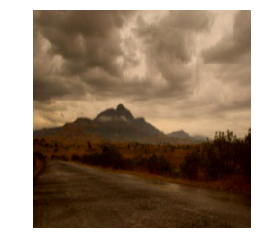

In [31]:
myimshow(y[0].detach())

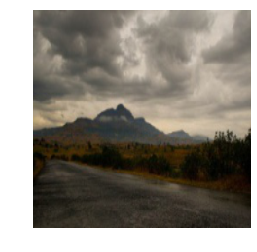

In [32]:
myimshow(X[0])

In [33]:
z=F(y)
print(z[0].shape)

torch.Size([3, 224, 224])


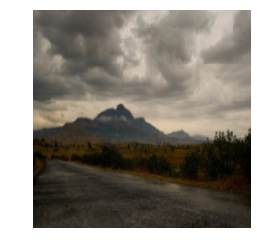

In [35]:
myimshow(z[0].detach())

# Plot loss